Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.


Retrieving SummaryDoc documents:   0%|          | 0/430 [00:00<?, ?it/s]

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

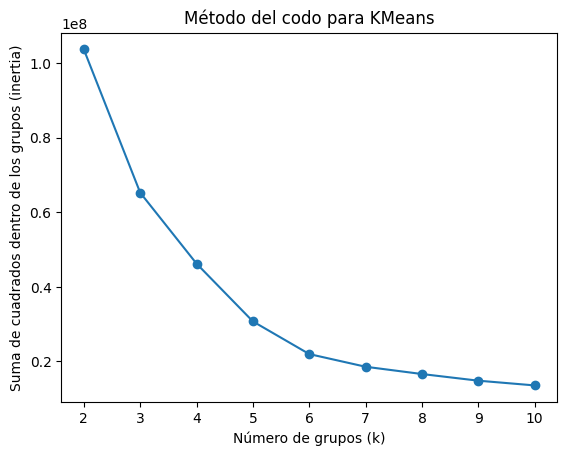

In [16]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mp_api.client import MPRester
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf

# Conectar con la base de datos de materials project usando la API de pymatgen
# Reemplaza "YOUR_API_KEY" con tu clave de API obtenida desde el sitio web de materials project
mpr = MPRester("Q4KseBQeiCIFmpyIzcxTaWeQ0DVWzyZf")

# Obtener los datos de materiales que quieres analizar
# En este ejemplo, se obtienen los datos de los óxidos binarios con una energía de formación menor que -1 eV/átomo
# Se seleccionan las propiedades: identificador del material (material_id), fórmula reducida (reduced_cell_formula), energía de formación (formation_energy_per_atom) y volumen (volume)
docs = mpr.summary.search(elements=["Si", "O"], 
                          band_gap=(0.5, 1.0))

# Convertir los resultados en un dataframe
df = pd.DataFrame([material.__dict__ for material in docs])

# df = pd.read_csv('mat_doc')
# df = df[0:500]

# Aplicar algún método de reducción de dimensionalidad o selección de características para simplificar los datos
# En este ejemplo, se usa la función auto_featurize de matminer para generar automáticamente características a partir de la composición química
# Se usan las siguientes clases de características: ElementProperty, Stoichiometry, ValenceOrbital, IonProperty y ElementFraction
feature_classes = [cf.ElementProperty.from_preset("magpie"), cf.Stoichiometry(), cf.ValenceOrbital(props=["avg"]), cf.IonProperty(), cf.ElementFraction()]
featurizer = MultipleFeaturizer(feature_classes)
X = featurizer.fit_transform(df['composition'])

X_df = pd.DataFrame(X)
X_df = X_df.dropna(axis=1) # Eliminar las columnas con valores nulos

# Elegir un algoritmo de clustering adecuado para los datos
# En este ejemplo, se usa el algoritmo KMeans de sklearn para agrupar los datos en k grupos según su similitud
# Se elige el valor de k usando el método del codo, que consiste en variar el valor de k y observar el cambio en la suma de cuadrados dentro de los grupos (inertia)
ks = range(2, 11) # Probar valores de k entre 2 y 10
inertias = [] # Lista para guardar los valores de inertia para cada k
for k in ks:
    # Crear el modelo de KMeans con k grupos
    model = KMeans(n_clusters=k, random_state=0)
    # Entrenar el modelo con los datos
    model.fit(X_df)
    # Añadir el valor de inertia a la lista
    inertias.append(model.inertia_)

# Graficar los valores de k e inertia
plt.plot(ks, inertias, "-o")
plt.xlabel("Número de grupos (k)")
plt.ylabel("Suma de cuadrados dentro de los grupos (inertia)")
plt.title("Método del codo para KMeans")
plt.show()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Coeficiente de silueta: 0.47
Índice Davies-Bouldin: 0.56


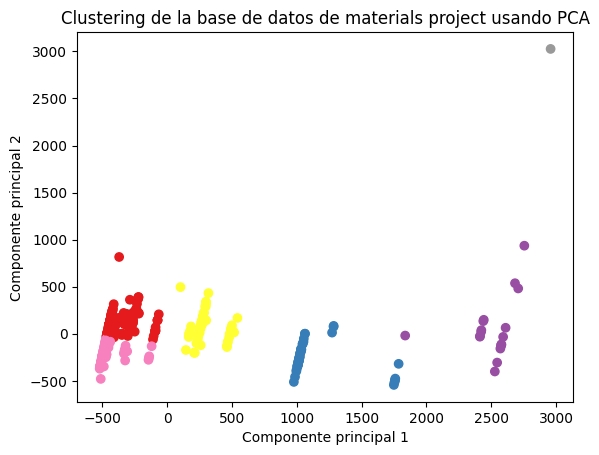

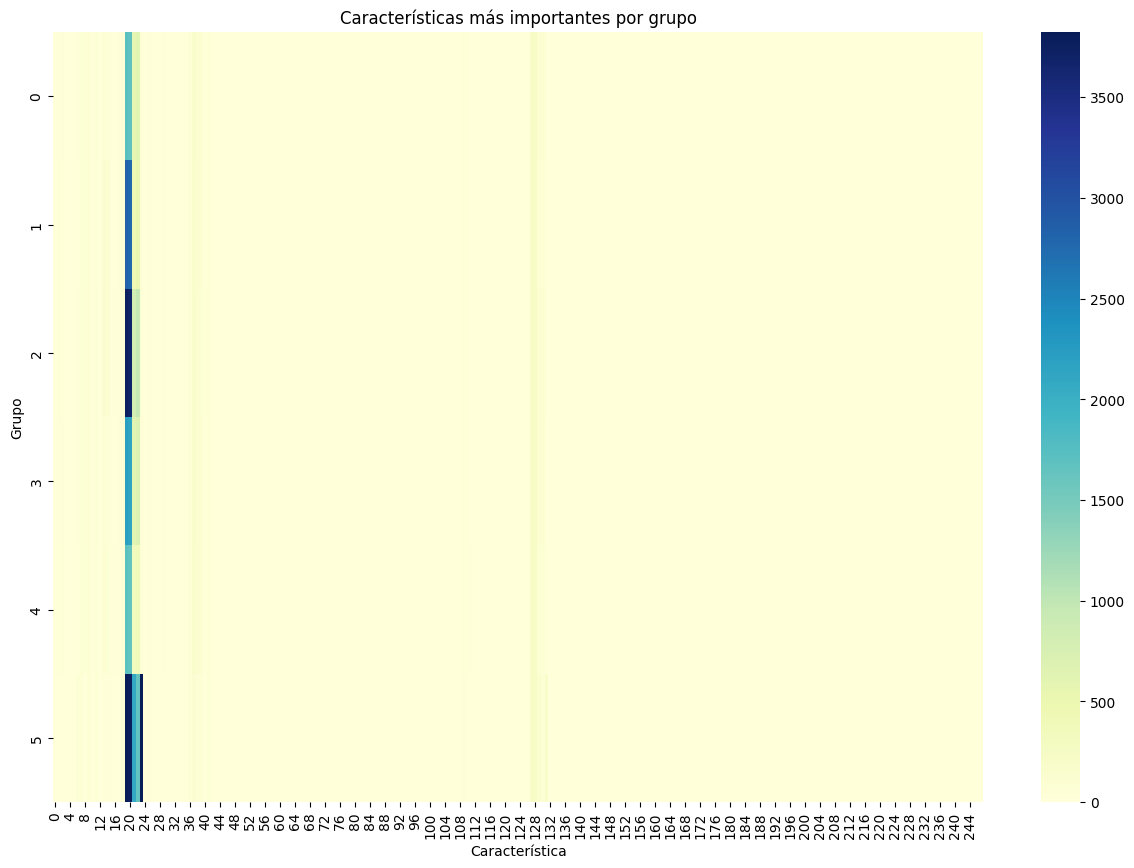

In [9]:
# Según la gráfica, se observa que el valor óptimo de k es 6, ya que a partir de ese punto la curva se suaviza
# Por lo tanto, se crea el modelo de KMeans con k=6 y se obtienen las etiquetas de los grupos asignados a cada material
model = KMeans(n_clusters=6, random_state=0)
model.fit(X_df)
labels = model.labels_

# Evaluar el resultado del clustering usando alguna medida de calidad
# En este ejemplo, se usan el coeficiente de silueta y el índice Davies-Bouldin, que miden la cohesión y la separación de los grupos
# El coeficiente de silueta varía entre -1 y 1, siendo 1 el mejor valor posible
# El índice Davies-Bouldin varía entre 0 e infinito, siendo 0 el mejor valor posible
silhouette = silhouette_score(X_df, labels)
davies_bouldin = davies_bouldin_score(X_df, labels)
print(f"Coeficiente de silueta: {silhouette:.2f}")
print(f"Índice Davies-Bouldin: {davies_bouldin:.2f}")

# Visualizar el resultado del clustering usando alguna técnica de proyección o gráfica
# En este ejemplo, se usa el análisis de componentes principales (PCA) para reducir la dimensionalidad de los datos a dos dimensiones y graficar los puntos con colores según su grupo
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_df)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="Set1")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("Clustering de la base de datos de materials project usando PCA")
plt.show()

# También se puede usar un mapa térmico (heatmap) para visualizar las características más importantes para cada grupo
# Para ello, se calcula la media de cada característica por grupo y se grafica con un gradiente de color
df_features = pd.DataFrame(X)
df_features["group"] = labels
df_group_mean = df_features.groupby("group").mean()
plt.figure(figsize=(15, 10))
sns.heatmap(df_group_mean, cmap="YlGnBu")
plt.xlabel("Característica")
plt.ylabel("Grupo")
plt.title("Características más importantes por grupo")
plt.show()

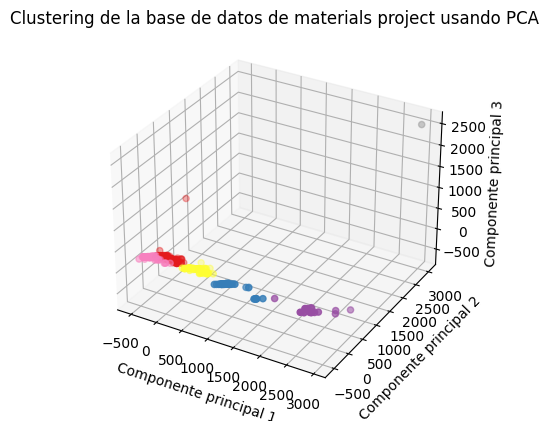

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap="Set1")

ax.set_xlabel("Componente principal 1")
ax.set_ylabel("Componente principal 2")
ax.set_zlabel("Componente principal 3")
plt.title("Clustering de la base de datos de materials project usando PCA")
plt.show()


In [12]:
# Imprimir la varianza explicada por cada componente principal
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

# Imprimir los coeficientes de las variables originales en las componentes principales
print("\nCoeficientes de las variables originales en las componentes principales:")
print(pca.components_)

Varianza explicada por cada componente:
[0.84855944 0.09176778 0.04265384]

Coeficientes de las variables originales en las componentes principales:
[[ 1.55750681e-04  3.39498830e-03  3.23923762e-03 -1.38618647e-04
  -2.02976311e-05 -1.44447867e-04  1.31435968e-03 -1.55607632e-04
  -1.46996732e-03  1.51364113e-04 -6.98316919e-05 -1.04067565e-05
   3.05511000e-04  8.65757215e-03  8.35206115e-03 -2.89799894e-04
   4.09338212e-05 -3.20833213e-04  8.90013266e-04  6.99592494e-01
   6.98702481e-01  9.00361131e-02  1.10542454e-01  4.31799764e-02
   9.12116651e-05 -1.62942143e-05 -1.07505879e-04 -8.32130646e-05
   8.17063937e-05 -1.08313868e-04  2.17202216e-05  1.89175262e-04
   1.67455041e-04 -1.59444108e-05 -8.89769698e-06 -1.33589805e-05
   7.88214564e-04  7.46121973e-04 -4.20925909e-05 -4.24890790e-04
  -3.19691780e-05 -3.28084550e-04  2.78786723e-05 -2.74763113e-06
  -3.06263034e-05  1.91040992e-05 -2.81422432e-05 -1.09072903e-05
  -2.80337932e-05 -0.00000000e+00  2.80337932e-05 -7.143288

In [13]:
df

,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_IDs,fields_not_requested
0,emmet_version='0.38.6' pymatgen_version='2022....,52,"[Al, N, Na, O, Si]",5,"(Na, Al, Si, N, O)","(Na, Al, Si, N, O)",Na4Al3Si3NO15,AB3C3D4E15,Al-N-Na-O-Si,784.781251,...,None,None,None,None,None,"[O-, Al3+, O2-, Si4+, N3+, Na+]","[HasProps.oxi_states, HasProps.thermo, HasProp...",True,{},[]
1,emmet_version='0.38.6' pymatgen_version='2022....,222,"[Ca, Na, Nb, O, S, Si]",6,"(Na, Ca, Nb, Si, S, O)","(Na, Ca, Nb, Si, S, O)",Na18Ca20Nb4Si3(S11O48)3,A3B4C18D20E33F144,Ca-Na-Nb-O-S-Si,3514.708431,...,None,None,None,None,None,"[O2-, Si4+, S6+, Ca2+, Na+, Nb5+]","[HasProps.electronic_structure, HasProps.mater...",True,{},[]
2,emmet_version='0.38.6' pymatgen_version='2022....,108,"[Na, Nb, O, S, Sc, Si]",6,"(Na, Sc, Nb, Si, S, O)","(Na, Sc, Nb, Si, S, O)",Na2Sc2Nb2Si3(SO8)3,A2B2C2D3E3F24,Na-Nb-O-S-Sc-Si,1591.805634,...,None,None,None,None,None,"[Si4+, S6+, Sc3+, O2-, Nb5+, Na+]","[HasProps.magnetism, HasProps.oxi_states, HasP...",True,{},[]
3,emmet_version='0.38.6' pymatgen_version='2022....,108,"[Mg, Na, O, S, Si, Sn]",6,"(Na, Mg, Si, Sn, S, O)","(Na, Mg, Si, Sn, S, O)",Na2Mg2SiSn2S5O24,AB2C2D2E5F24,Mg-Na-O-S-Si-Sn,1508.780984,...,None,None,None,None,None,"[Si4+, O2-, Mg2+, S6+, Na+, Sn4+]","[HasProps.thermo, HasProps.provenance, HasProp...",True,{},[]
4,emmet_version='0.38.6' pymatgen_version='2022....,32,"[Mg, O, Si, Ti]",4,"(Mg, Ti, Si, O)","(Mg, Ti, Si, O)",Mg14TiSiO16,ABC14D16,Mg-O-Si-Ti,318.802778,...,None,None,None,None,None,"[Si2+, O2-, Ti2+, Mg2+]","[HasProps.oxi_states, HasProps.substrates, Has...",True,{},[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,emmet_version='0.38.6' pymatgen_version='2022....,116,"[Ca, H, K, O, Si]",5,"(K, Ca, Si, H, O)","(K, Ca, Si, H, O)",KCa4Si8H16O29,AB4C8D16E29,Ca-H-K-O-Si,1318.683030,...,None,None,None,None,None,"[K+, Ca2+, Si4+, O-, O2-, H+]","[HasProps.magnetism, HasProps.electronic_struc...",False,{'icsd': ['icsd-100609']},[]
426,emmet_version='0.38.6' pymatgen_version='2022....,35,"[Mg, Mn, O, Si]",4,"(Mg, Mn, Si, O)","(Mg, Mn, Si, O)",MgMn4(Si4O11)2,AB4C8D22,Mg-Mn-O-Si,460.083874,...,None,None,None,None,None,"[O2-, Mn2+, Mn3+, Mg2+, Si4+]","[HasProps.electronic_structure, HasProps.magne...",True,{},[]
427,emmet_version='0.38.6' pymatgen_version='2022....,46,"[Be, Cd, O, S, Si]",5,"(Be, Cd, Si, S, O)","(Be, Cd, Si, S, O)",Be3Cd4Si3SO12,AB3C3D4E12,Be-Cd-O-S-Si,627.314345,...,None,None,None,None,None,"[S2-, Cd2+, O2-, Si4+, Be2+]","[HasProps.piezoelectric, HasProps.materials, H...",False,{'icsd': ['icsd-81485']},[]
428,emmet_version='0.38.6' pymatgen_version='2022....,14,"[Fe, O, Si]",3,"(Fe, Si, O)","(Fe, Si, O)",Fe2SiO4,AB2C4,Fe-O-Si,140.370767,...,None,None,None,None,None,"[Si4+, Fe2+, O2-]","[HasProps.electronic_structure, HasProps.therm...",False,"{'icsd': ['icsd-238760', 'icsd-238758', 'icsd-...",[]
